Enrico Convento -- id:2023572

Load the following file to avoid to re-run the parameter study:


*   params_sol1
*   scores_sol1



# Cart pole using state

In [1]:
!pip install pyvirtualdisplay
!pip install hiplot

     |████████████████████████████████| 862 kB 8.6 MB/s 
     |████████████████████████████████| 792 kB 39.1 MB/s 
     |████████████████████████████████| 380 kB 13.1 MB/s 
     |████████████████████████████████| 357 kB 43.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.28 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.31.1 which is incompatible.


In [2]:
# Numpy
import random
import numpy as np

# Miscellaneous
import glob
import io
import base64
import os
from tqdm.notebook import tqdm

# Visualization
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import matplotlib.pyplot as plt
import hiplot as hip
import plotly.express as px

# Neural network
from torch import nn
import torch

# Reinforcement learning
from collections import deque # this python module implements exactly what we need for the replay memeory
import gym

seed = 0
# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
replay_memory_capacity = 10000   # Replay memory capacity
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

## Colab setup

In [4]:
## Rendering section ##

!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [917 kB]
Hit:13 http://ppa.laun

# Experience replay

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

# Policies

In [6]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [7]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

# DQN

In [8]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [9]:
print(f"TEST")
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

TEST
ACTION: 1
Q-VALUES: [ 0.0044669  -0.00997963]


#Exploration Profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

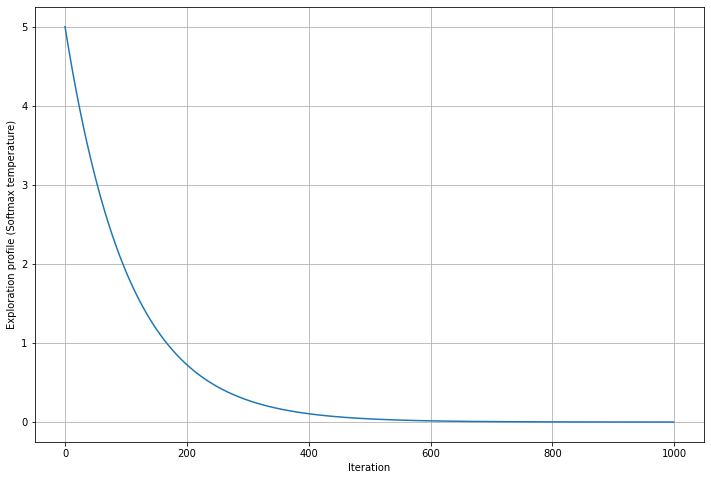

In [10]:
def softmax_expl(num_iterations=1000, initial_value=5):
    # We compute the exponential decay in such a way the shape of the exploration 
    # profile does not depend on the number of iterations
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

### Define exploration profile
exploration_profile = softmax_expl()

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Training

In [12]:
class Training():
  '''
  Class for training an agent.

  Args:
    params
    replay_memory_capacity
    state_space_dim
    action_space_dim
  '''
  def __init__(self, params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    self.replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    self.policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    self.target_net = DQN(state_space_dim, action_space_dim)
    self.target_net.load_state_dict(self.policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    self.params = params
    ### Initialize the optimizer
    self.optimizer = torch.optim.SGD(self.policy_net.parameters(), lr= self.params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    self.loss_fn = nn.SmoothL1Loss()
    


    self.state_space_dim = state_space_dim
    self.action_space_dim = action_space_dim

  def train(self, exploration_profile, verbose=False, vanilla_version = False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(self.policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            if vanilla_version == False:
              reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += self.params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            self.replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(self.replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                self.update_step()

            # Visually render the environment (disable to speed up the training)
            if episode_num % 100 == 0:
                env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % self.params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            self.target_net.load_state_dict(self.policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return self.policy_net, training_score


 
  ## Network update
  def update_step(self):
        
    # Sample the data from the replay memory
    batch = self.replay_mem.sample(self.params['batch_size'])
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = torch.tensor(np.array([s[0] for s in batch]), dtype=torch.float32)
    actions = torch.tensor(np.array([s[1] for s in batch]), dtype=torch.int64)
    rewards = torch.tensor(np.array([s[3] for s in batch]), dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)

    # Compute all the Q values (forward pass)
    self.policy_net.train()
    q_values = self.policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        self.target_net.eval()
        q_values_target = self.target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * self.params['gamma'])
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = self.loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(self.policy_net.parameters(), 2)
    self.optimizer.step()

## Solution 1

In [ ]:
### PARAMETERS
params = {}
params['gamma'] = 0.97  # gamma parameter for the long term reward

params['lr'] = 0.05   # Optimizer learning rate
params['target_net_update_steps'] = 10  # Number of episodes to wait before updating the target network
params['batch_size'] = 128  # Number of samples to take from the replay memory for each update
params['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialization
trainer = Training(params)

### Training
policy_net, training_score = trainer.train(exploration_profile, verbose=False, vanilla_version = True)

  0%|          | 0/1000 [00:00<?, ?it/s]

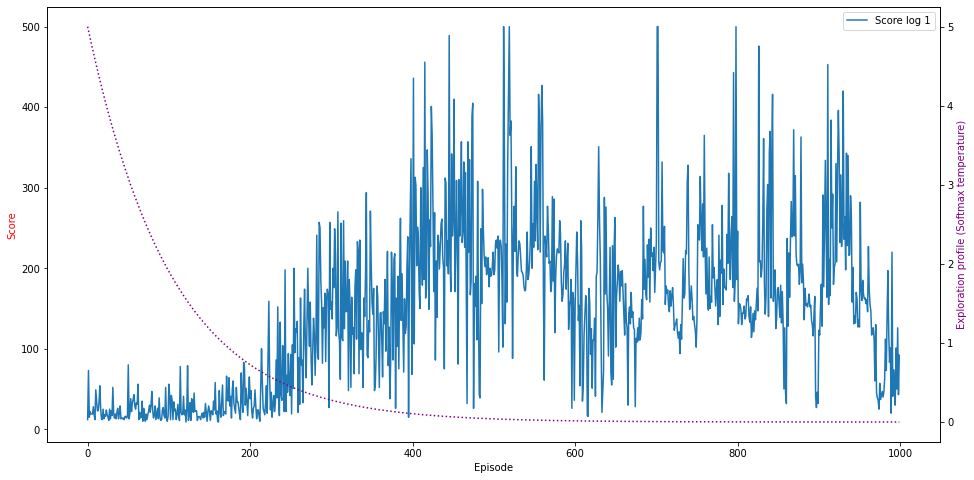

In [ ]:
t = np.arange(0, 1000, 1)
fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Episode')
ax.set_ylabel('Score', color='red')
trial_counter = 1;
ax.plot(t, training_score, label="Score log {}".format(trial_counter))
ax1 = ax.twinx()
ax1.plot(exploration_profile, color='purple', linestyle='dotted')
ax1.set_ylabel('Exploration profile (Softmax temperature)', color='purple')
ax.legend()

## Solution 2

In [ ]:
### PARAMETERS
params = {}
params['gamma'] = 0.97  # gamma parameter for the long term reward

params['lr'] = 0.05   # Optimizer learning rate
params['target_net_update_steps'] = 10  # Number of episodes to wait before updating the target network
params['batch_size'] = 128  # Number of samples to take from the replay memory for each update
params['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

### Initialization
trainer = Training(params)

### Training
policy_net, training_score = trainer.train(exploration_profile, verbose=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

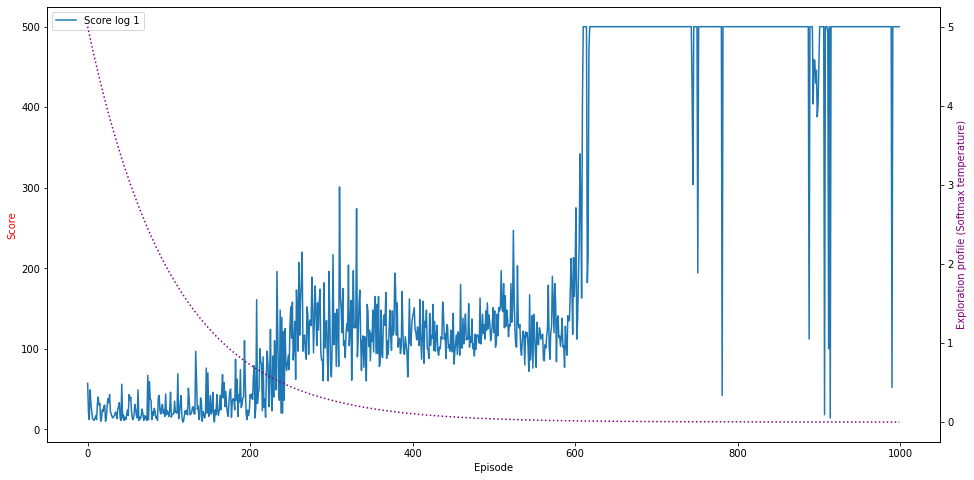

In [ ]:
t = np.arange(0, 1000, 1)
fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Episode')
ax.set_ylabel('Score', color='red')
trial_counter = 1;
ax.plot(t, training_score, label="Score log {}".format(trial_counter))
ax1 = ax.twinx()
ax1.plot(exploration_profile, color='purple', linestyle='dotted')
ax1.set_ylabel('Exploration profile (Softmax temperature)', color='purple')
ax.legend()

## Parameters exploration

In [ ]:
## run this cell to re-perform the study ##
params_tot = []
tr_score_tot = []
expl_prof_tot = []

TRIALS = 5
exploration_profile = softmax_expl()

gamma = np.linspace(0.9, 0.99, 10)
lr = np.logspace(-3, -1, 10)
batch_size = [32, 64, 128, 256]
target_net_update_steps = np.arange(5, 25, 5, dtype=int)


for i in range(TRIALS):
    
    
    ### PARAMETERS
    params = {}
    params['gamma'] = np.random.choice(gamma)   # gamma parameter for the long term reward
    
    params['lr'] = np.random.choice(lr)   # Optimizer learning rate
    params['target_net_update_steps'] = np.random.choice(target_net_update_steps)   # Number of episodes to wait before updating the target network
    params['batch_size'] = np.random.choice(batch_size)  # Number of samples to take from the replay memory for each update
    params['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

    ### Initialization
    trainer = Training(params)
    
    ### Training
    policy_net, training_score = trainer.train(exploration_profile, verbose=False)
    
    params_tot.append(params)
    tr_score_tot.append(training_score)
    expl_prof_tot.append(exploration_profile)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
import pickle
## SAVE SCORES AND PARAMS ##
'''
with open("scores", "wb") as fp:   #Pickling
  pickle.dump(tr_score_tot, fp)
with open("params", "wb") as fp:   #Pickling
  pickle.dump(params_tot, fp)
'''
episodes_trajectories = []
## LOAD SCORES AND PARAMS ##
with open("scores_sol1", "rb") as fp:   # Unpickling
  episodes_trajectories = pickle.load(fp)
with open("params_sol1", "rb") as fp:   # Unpickling
  params_tot = pickle.load(fp)

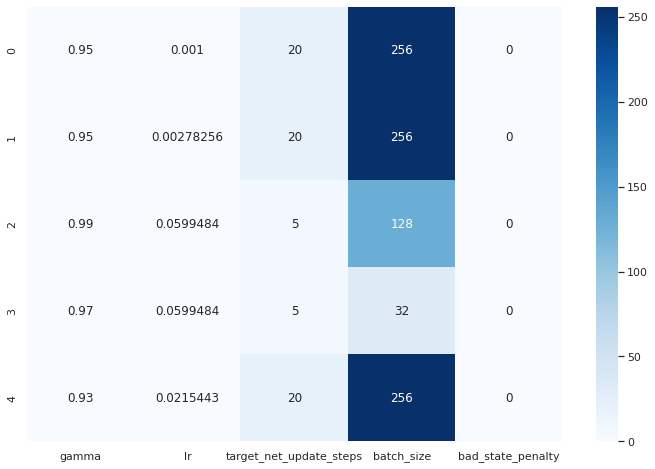

In [14]:
import pandas as pd
import seaborn as sns

sns.set(rc={"figure.figsize":(12,8)})

df = pd.DataFrame(params_tot)
g = sns.heatmap(df, cmap="Blues", annot=True, fmt='g')
g.get_figure().savefig("heatmap.png")

In [15]:
params_tot[3]


{'bad_state_penalty': 0,
 'batch_size': 32,
 'gamma': 0.97,
 'lr': 0.05994842503189409,
 'target_net_update_steps': 5}

# Plotting results

In [16]:
def averaging(signal, freq=20):
    new_signal = []
    new_pos = []
    for i in range(len(signal)//freq):
        new_signal.append( signal[i*freq:(i+1)*freq].mean() )
        new_pos.append( (i*freq+(i+1)*freq)/2 )
    return new_pos, new_signal



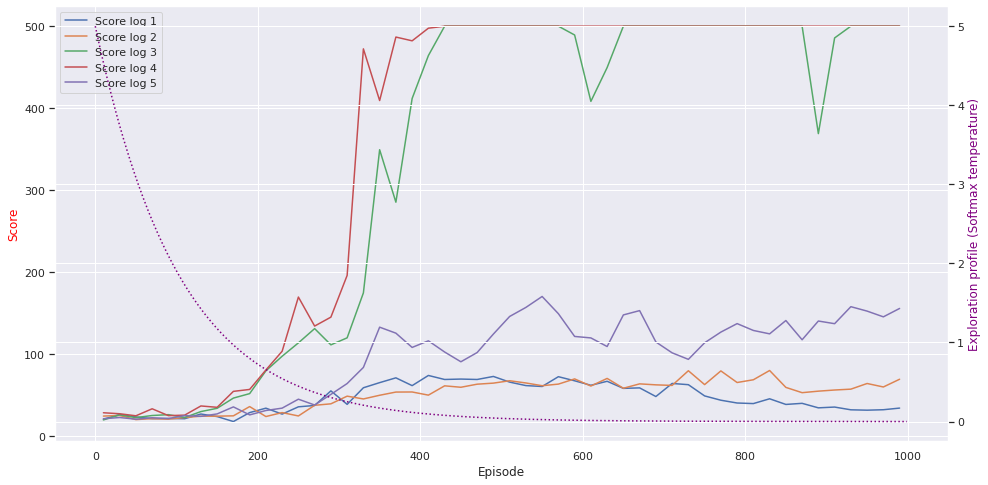

In [17]:
t = np.arange(0, 1000, 1)



fig, ax = plt.subplots(figsize=(16, 8))

ax.set_xlabel('Episode')
ax.set_ylabel('Score', color='red')
trial_counter = 1;
for trial in episodes_trajectories:
  x, y = averaging(np.array(trial))
  ax.plot(x, y, label="Score log {}".format(trial_counter))
  trial_counter += 1
ax1 = ax.twinx()
ax1.plot(exploration_profile, color='purple', linestyle='dotted')
ax1.set_ylabel('Exploration profile (Softmax temperature)', color='purple')
ax.legend()

# Final test

In [18]:
### Initialization
trainer = Training(params_tot[3])

### Training
policy_net, training_score = trainer.train(exploration_profile, verbose=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

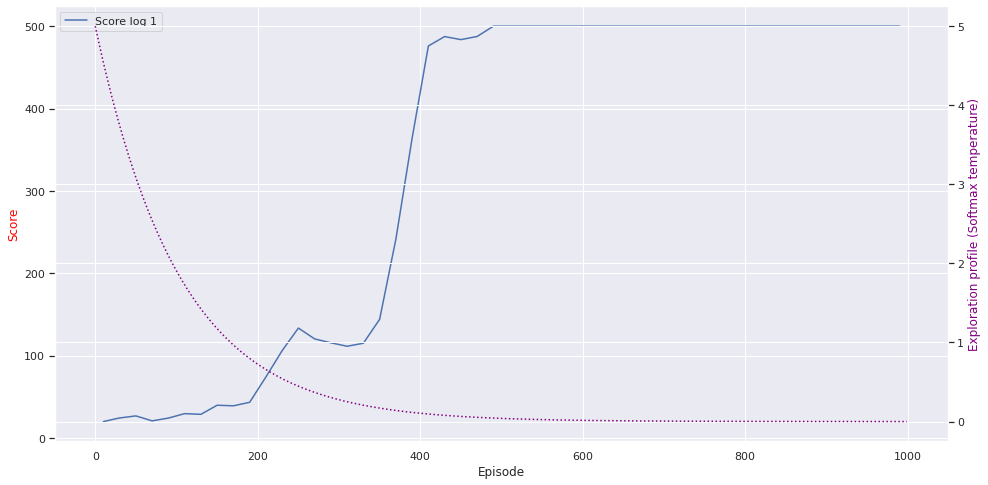

In [19]:
t = np.arange(0, 1000, 1)

# from scipy.interpolate import make_interp_spline # make smooth version
# interpol = make_interp_spline(t, score_mean, k=3)  # type: BSpline

fig, ax = plt.subplots(figsize=(16, 8))
#ax.fill_between(t, np.maximum(score_mean - score_std, 0), np.minimum(score_mean + score_std, 800), color='b', alpha=0.2)
# ax.legend(loc='upper right')
ax.set_xlabel('Episode')
ax.set_ylabel('Score', color='red')
trial_counter = 1;
x, y = averaging(np.array(training_score))
ax.plot(x, y, label="Score log {}".format(trial_counter))
ax1 = ax.twinx()
ax1.plot(exploration_profile, color='purple', linestyle='dotted')
ax1.set_ylabel('Exploration profile (Softmax temperature)', color='purple')
ax.legend()

In [20]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0
